In [ ]:
!pip install -Uqq nixtla datasetsforecast utilsforecast dask-expr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.5/244.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae

In [ ]:
nixtla_client = NixtlaClient(
    api_key = 'nixak-nlPrQBgeS2R3k0n0oRrvcAQlkE7trLo9Nyspwz3mMFeZqSu6fdfHa0xMkjzsaD5z0WSEMEIOwBIQXX8j'
)

In [ ]:
Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')
Y_df.head()

100%|██████████| 314M/314M [00:10<00:00, 30.6MiB/s]


,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227


In [ ]:
test = Y_df[-96:]
input_seq = Y_df[-1104:-96]

In [ ]:
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=96,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

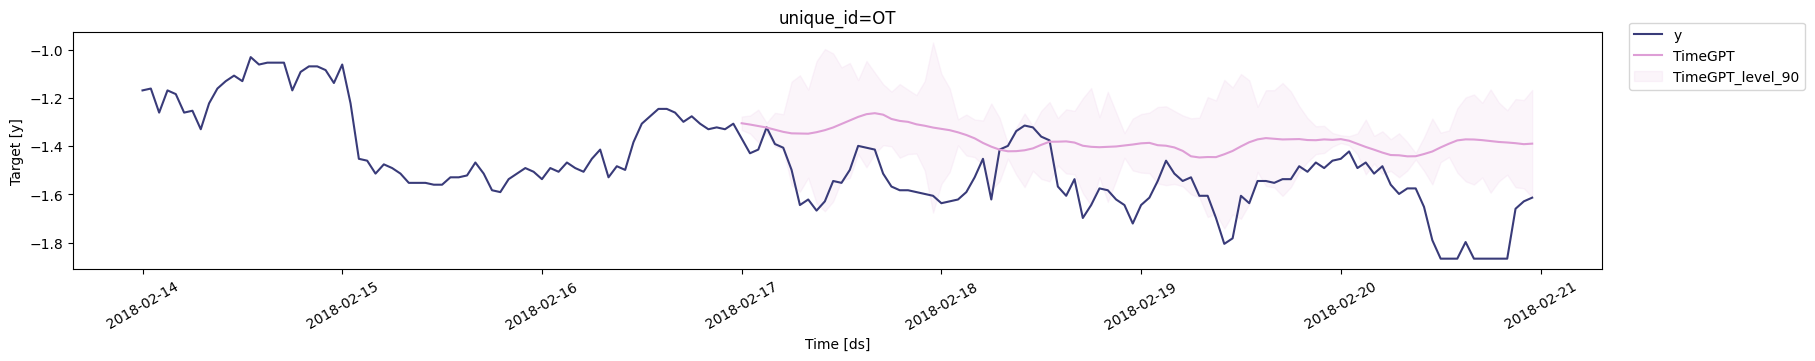

In [ ]:
nixtla_client.plot(Y_df[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [ ]:
test = test.copy()
test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [ ]:
evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')
print(evaluation)

  unique_id   TimeGPT
0        OT  0.205319


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df.head()

,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10


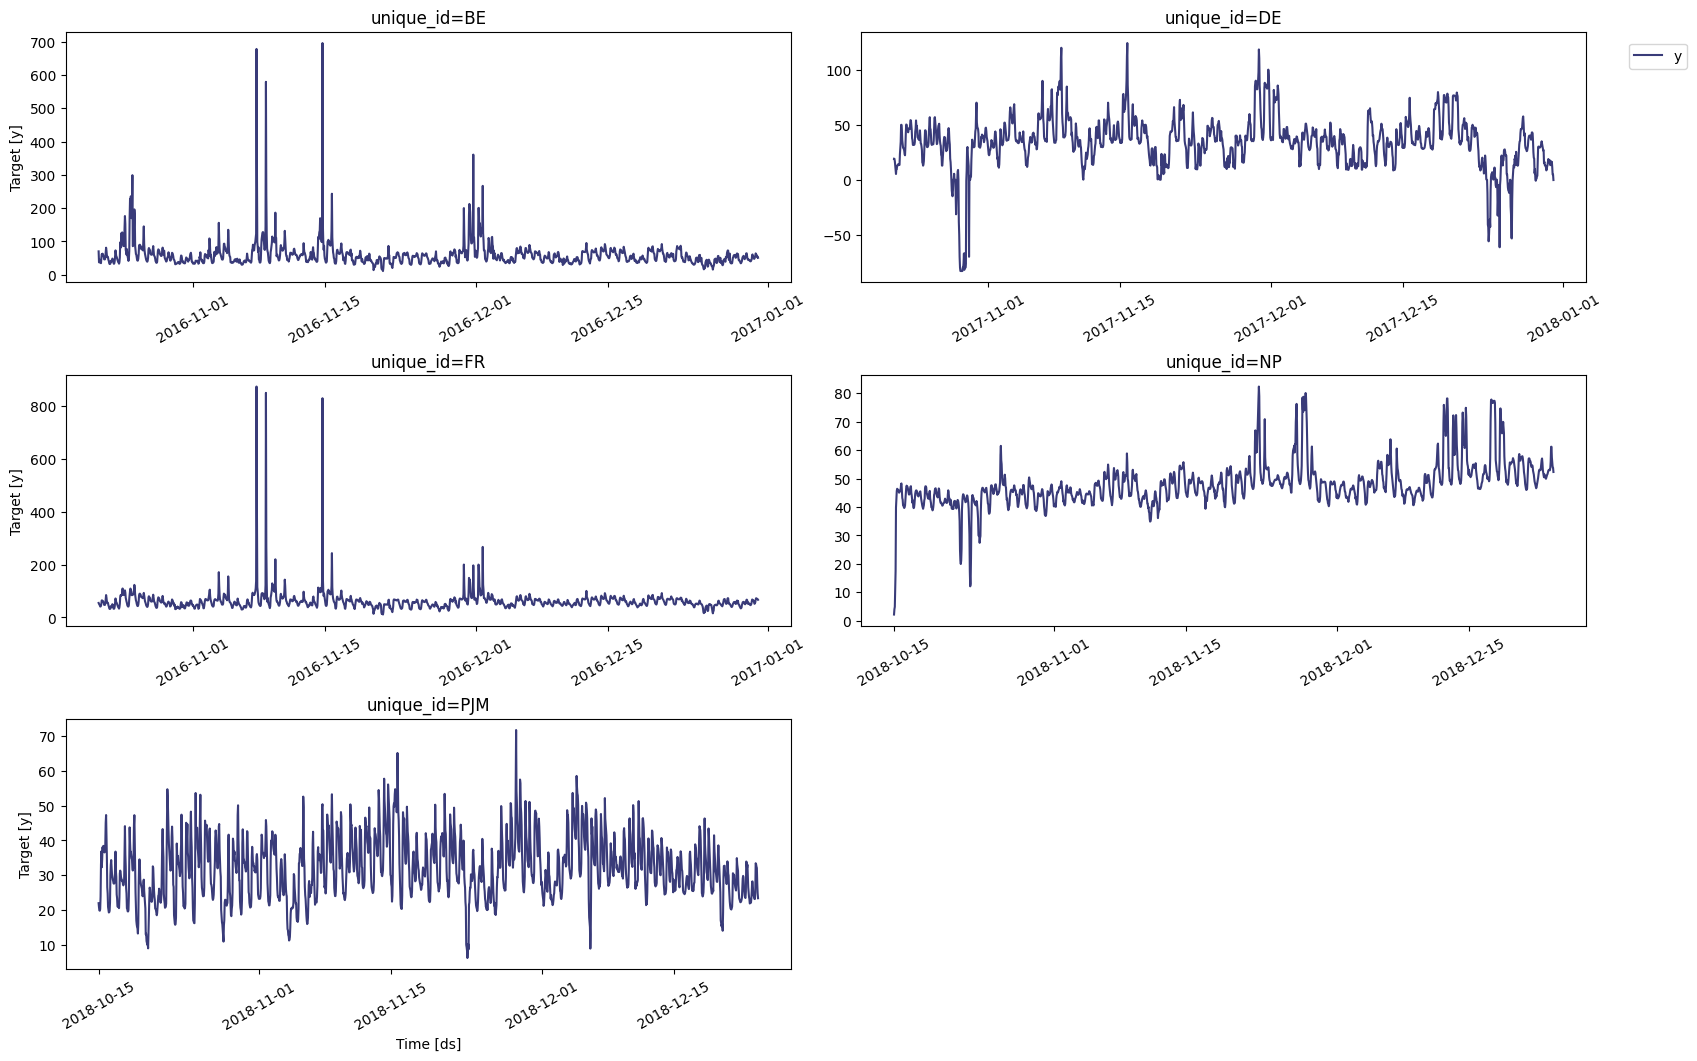

In [ ]:
nixtla_client.plot(df)

In [ ]:
timegpt_fcst_multiseries_df = nixtla_client.forecast(df=df, h=24, level=[80, 90])
timegpt_fcst_multiseries_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,45.190674,54.872640,57.369972,35.508710,33.011375
1,BE,2016-12-31 01:00:00,43.244910,51.113556,56.101364,35.376266,30.388454
2,BE,2016-12-31 02:00:00,41.958893,48.577103,54.632137,35.340683,29.285650
3,BE,2016-12-31 03:00:00,39.796677,47.265984,49.683872,32.327370,29.909481
4,BE,2016-12-31 04:00:00,39.204560,47.410786,47.677520,30.998333,30.731598


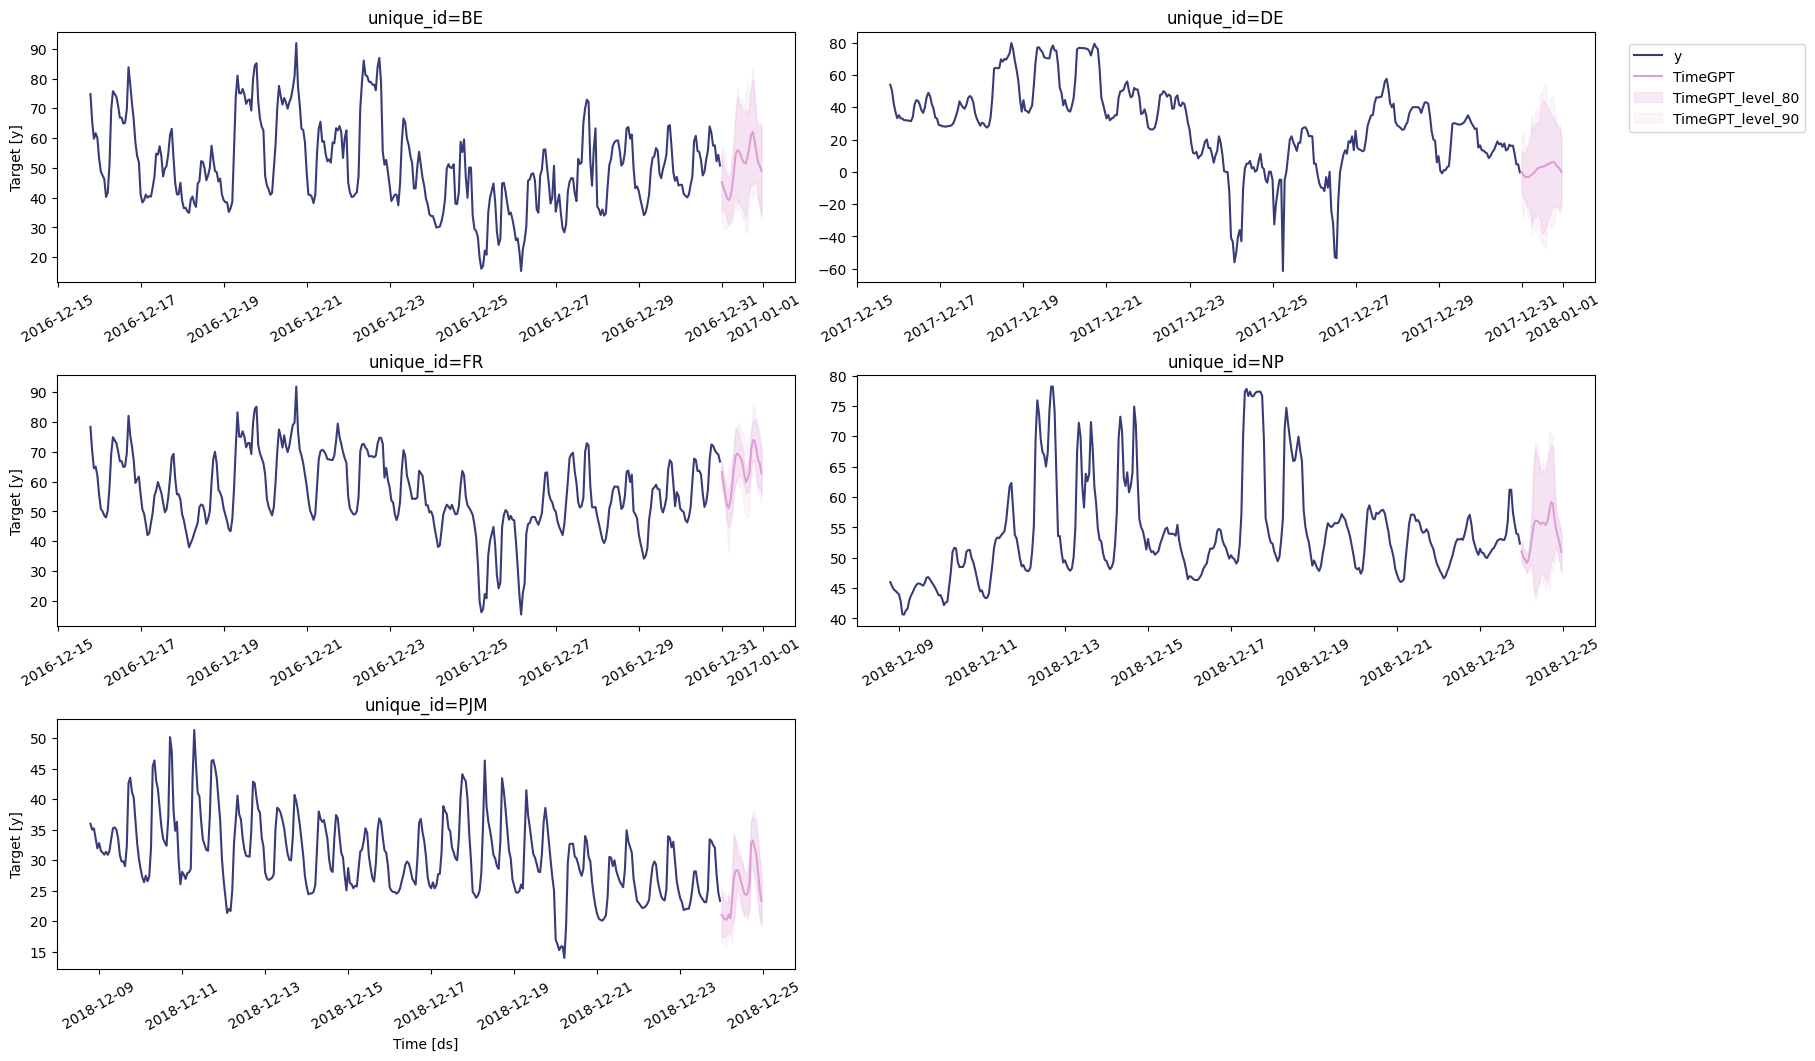

In [ ]:
nixtla_client.plot(df, timegpt_fcst_multiseries_df, max_insample_length=365, level=[80, 90])

In [ ]:
timegpt_fcst_multiseries_with_history_df = nixtla_client.forecast(df=df, h=24, level=[80, 90], add_history=True)
timegpt_fcst_multiseries_with_history_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-10-27 00:00:00,56.072560,98.19364,110.134380,13.951481,2.010740
1,BE,2016-10-27 01:00:00,52.413048,94.53413,106.474870,10.291969,-1.648771
2,BE,2016-10-27 02:00:00,52.805850,94.92693,106.867670,10.684772,-1.255968
3,BE,2016-10-27 03:00:00,52.581253,94.70233,106.643074,10.460175,-1.480566
4,BE,2016-10-27 04:00:00,52.667156,94.78824,106.728970,10.546078,-1.394663


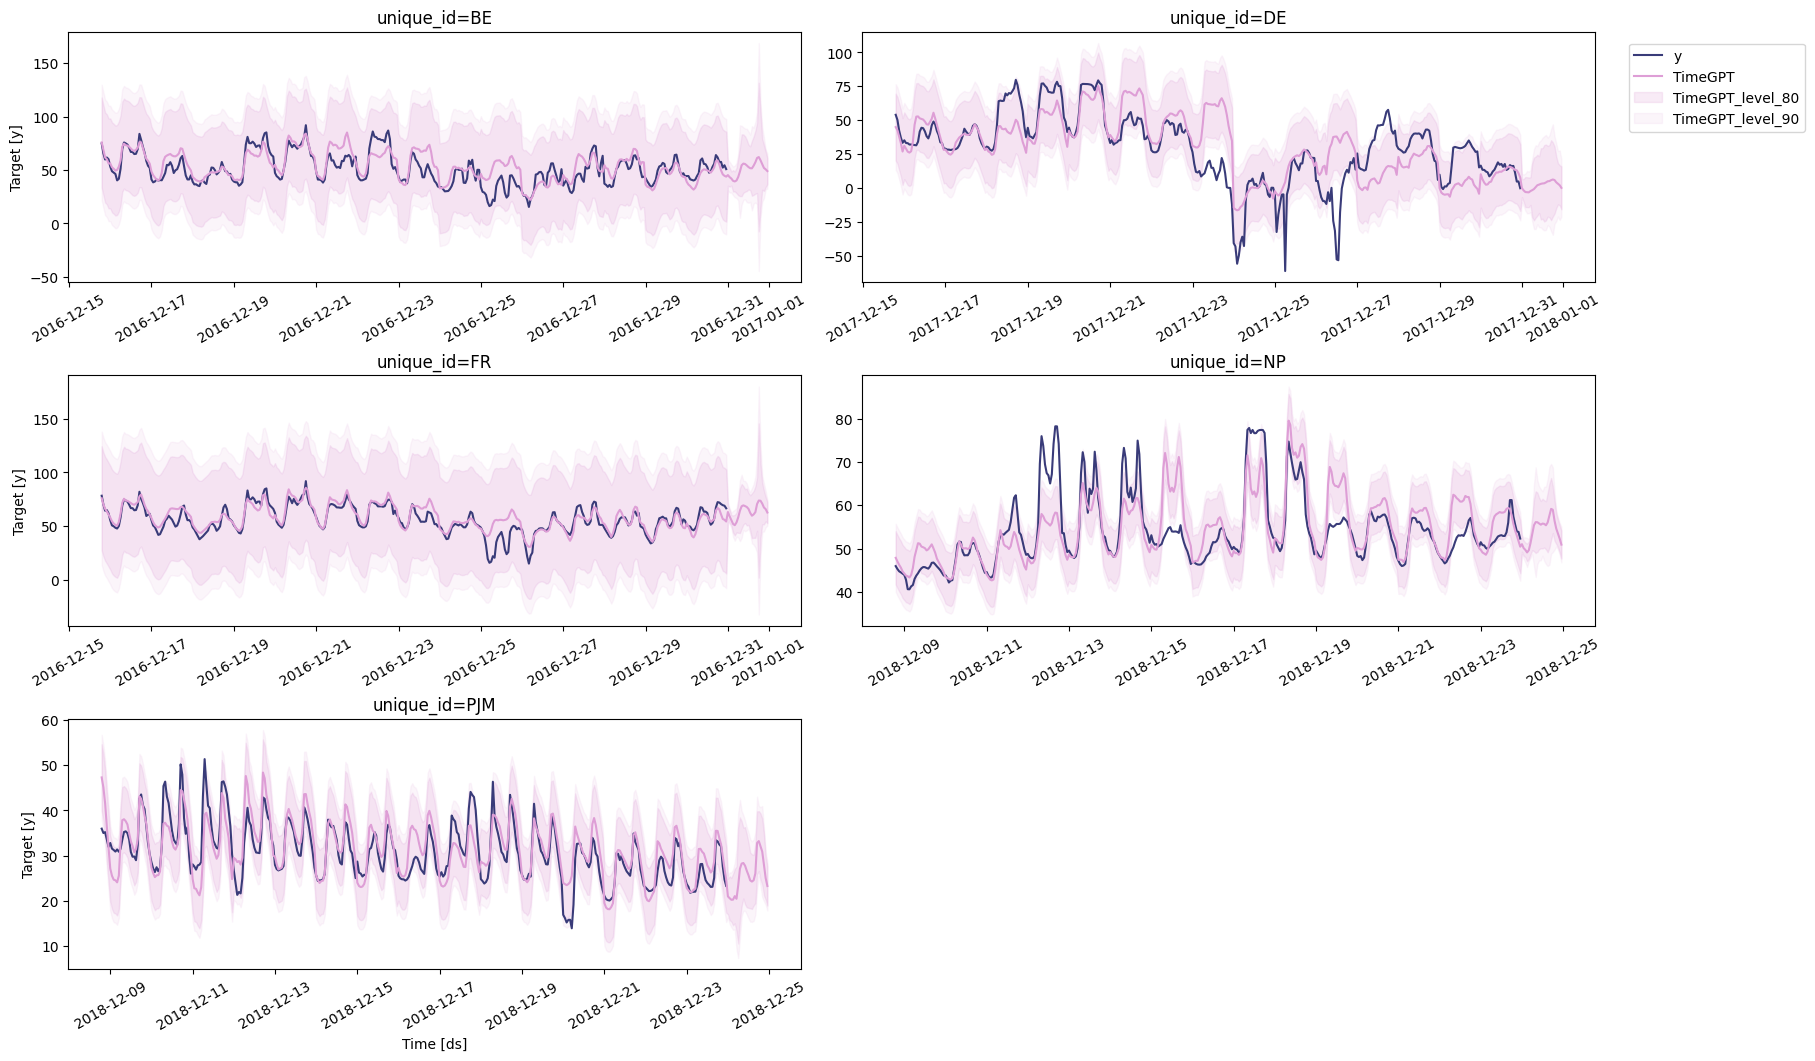

In [ ]:
nixtla_client.plot(
    df,
    timegpt_fcst_multiseries_with_history_df.groupby('unique_id').tail(365 + 24),
    max_insample_length=365,
    level=[80, 90],
)